In [1]:
from google.colab import files

# Upload Dataset.zip from your computer
uploaded = files.upload()

Saving Dataset.zip to Dataset.zip


In [3]:
import zipfile

# Extract Dataset.zip
with zipfile.ZipFile("Dataset.zip", "r") as zip_ref:
    zip_ref.extractall(".")

print("✅ Dataset unzipped!")


✅ Dataset unzipped!


In [5]:
import pandas as pd
df = pd.read_csv("IMDB Dataset.csv")
print(df.head())



                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [8]:
!pip install wordcloud gradio --quiet

In [6]:
import argparse
import os
import zipfile
import re
import shutil
import json
from pathlib import Path

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
)

import gradio as gr

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
def clean_text(text):
    text = str(text).lower()                         # lowercase
    text = re.sub(r"<.*?>", " ", text)               # remove HTML tags
    text = re.sub(r"[^a-z\s]", " ", text)            # remove punctuation & numbers
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_review'] = df['review'].apply(clean_text)

In [12]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'], df['sentiment'], test_size=0.2,
    random_state=42, stratify=df['sentiment']
)

In [15]:
vectorizers = {
    "CountVectorizer": CountVectorizer(max_features=5000, stop_words='english'),
    "TF-IDF": TfidfVectorizer(max_features=5000, stop_words='english')
}

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB()
}

In [16]:
results = []

for vec_name, vectorizer in vectorizers.items():
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    for model_name, model in models.items():
        model.fit(X_train_vec, y_train)
        y_pred = model.predict(X_test_vec)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results.append([model_name, vec_name, acc, f1])

        # Print detailed report
        print(f"\n=== {model_name} with {vec_name} ===")
        print("Accuracy:", acc)
        print("F1-score:", f1)
        print(classification_report(y_test, y_pred))


=== Logistic Regression with CountVectorizer ===
Accuracy: 0.8696
F1-score: 0.8701195219123506
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      5000
           1       0.87      0.87      0.87      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000


=== Naive Bayes with CountVectorizer ===
Accuracy: 0.8416
F1-score: 0.8413461538461539
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      5000
           1       0.84      0.84      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000


=== Logistic Regression with TF-IDF ===
Accuracy: 0.8855
F1-score: 0.8867793928606744
              precision    recall  f1-score   support

           0       0

In [17]:
results_df = pd.DataFrame(results, columns=["Model", "Vectorizer", "Accuracy", "F1-Score"])
print("\nSummary of Results:")
print(results_df)


Summary of Results:
                 Model       Vectorizer  Accuracy  F1-Score
0  Logistic Regression  CountVectorizer    0.8696  0.870120
1          Naive Bayes  CountVectorizer    0.8416  0.841346
2  Logistic Regression           TF-IDF    0.8855  0.886779
3          Naive Bayes           TF-IDF    0.8517  0.853212


In [18]:
best_row = results_df.sort_values(by="F1-Score", ascending=False).iloc[0]
best_vec = vectorizers[best_row["Vectorizer"]]
best_model = models[best_row["Model"]]

X_train_vec = best_vec.fit_transform(X_train)
X_test_vec = best_vec.transform(X_test)
best_model.fit(X_train_vec, y_train)
y_pred = best_model.predict(X_test_vec)

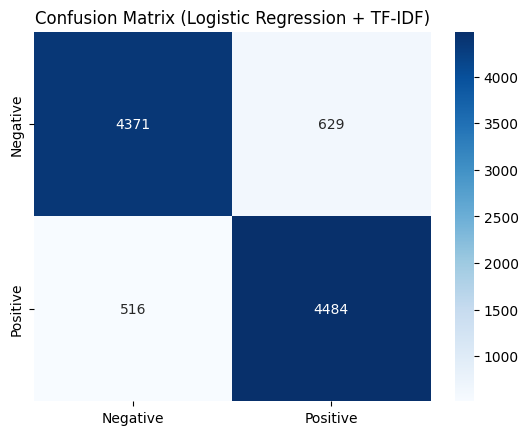

In [19]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Negative","Positive"],
            yticklabels=["Negative","Positive"])
plt.title(f"Confusion Matrix ({best_row['Model']} + {best_row['Vectorizer']})")
plt.show()

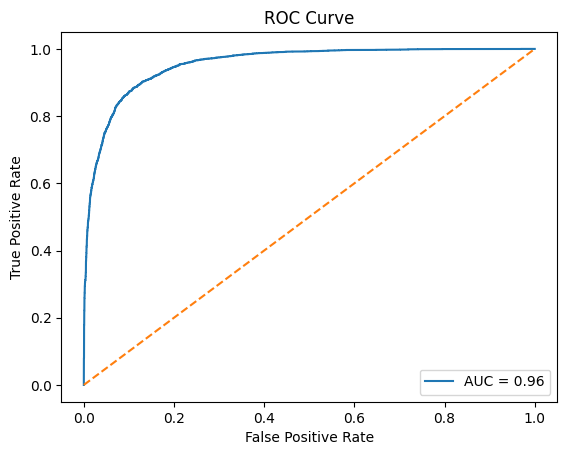

In [20]:
y_prob = best_model.predict_proba(X_test_vec)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

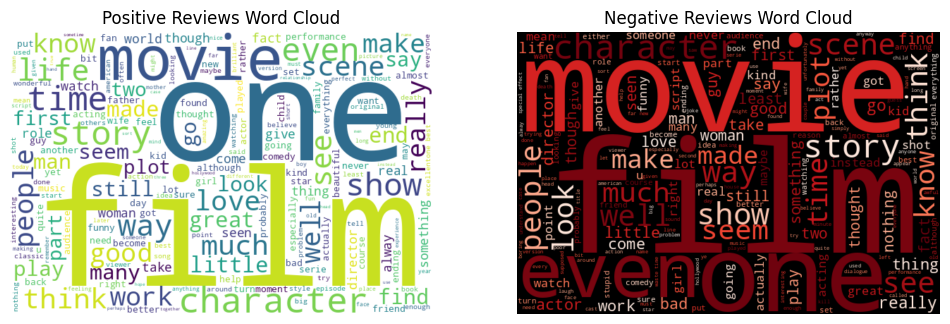

In [21]:
pos_text = " ".join(df[df['sentiment']==1]['clean_review'])
neg_text = " ".join(df[df['sentiment']==0]['clean_review'])

wordcloud_pos = WordCloud(width=600, height=400, background_color="white").generate(pos_text)
wordcloud_neg = WordCloud(width=600, height=400, background_color="black", colormap="Reds").generate(neg_text)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews Word Cloud")

plt.subplot(1,2,2)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.show()

In [22]:
def predict_sentiment(review):
    review_clean = clean_text(review)
    vec = best_vec.transform([review_clean])
    pred = best_model.predict(vec)[0]
    prob = best_model.predict_proba(vec)[0][pred]
    return "Positive 😀" if pred == 1 else "Negative 😞"

demo = gr.Interface(fn=predict_sentiment,
                    inputs=gr.Textbox(lines=3, placeholder="Type a movie review..."),
                    outputs="text",
                    title="IMDb Sentiment Classifier",
                    description="Enter a review and get sentiment prediction.")

In [23]:
demo.launch(share=True)  # share=True gives a public link

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://86b327ff74751adac9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
